### Example code repurposed and used to evaluate the ERCOT interconnection queue projects.

Some people check Twitter or Instagram regularly. I check the interconnetion queues of the US ISOs.

In the following lab, I explore the ERCOT interconnection queue a bit, cleaning the data, discussing what might be useful to join, and ultimately joining in the 
location data for US substations and exploring the location of the queue projects. It's a quick and dirty exercise from raw data from all public sources, but it yields so much potential for robust data science and product development from so few lines that it's worth talking about.



Data used here are:

1. ERCOT Interconnection Queue (as of June, [source, ERCOT](http://mis.ercot.com/misapp/GetReports.do?reportTypeId=15933&reportTitle=GIS%20Report&showHTMLView=&mimicKey))
2. GIS map layer of US Transmission system substations ([source](https://hifld-geoplatform.opendata.arcgis.com/datasets/electric-substations))
3. US Census shape data ([source](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html))


In [51]:
import pandas as pd

sheet_name = 'Project Details'
pathname = 'data/'
filename = 'IQ_Report_June_2020.xlsx'

# Useful to have a dictionary of IQ format cleaning variables for each ISO. Difficult to generalize a read_excel
# for every ISO. In the ERCOT files, you have to skip the first 23 rows to get to a header.

df = pd.read_excel(pathname+filename, sheet_name=sheet_name, header=24)
first_col = list(df)[0]
df = df[df[first_col].notnull()]

ERCOT does a bit of queue analysis in the sheets, specifically the GINR trends page. They have a useful graph that
is projected capacity by generator type by zone. 

![GINR Trends from ERCOT spreadsheet](ercot_queue_trends.png)

































But what if we want more granularity? With the data given, we can make the same graph by county.

<ipython-input-70-9675d5f921ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Year'] = pd.to_datetime(df_plot['Projected COD']).dt.to_period('Y')


<AxesSubplot:xlabel='Year,County'>

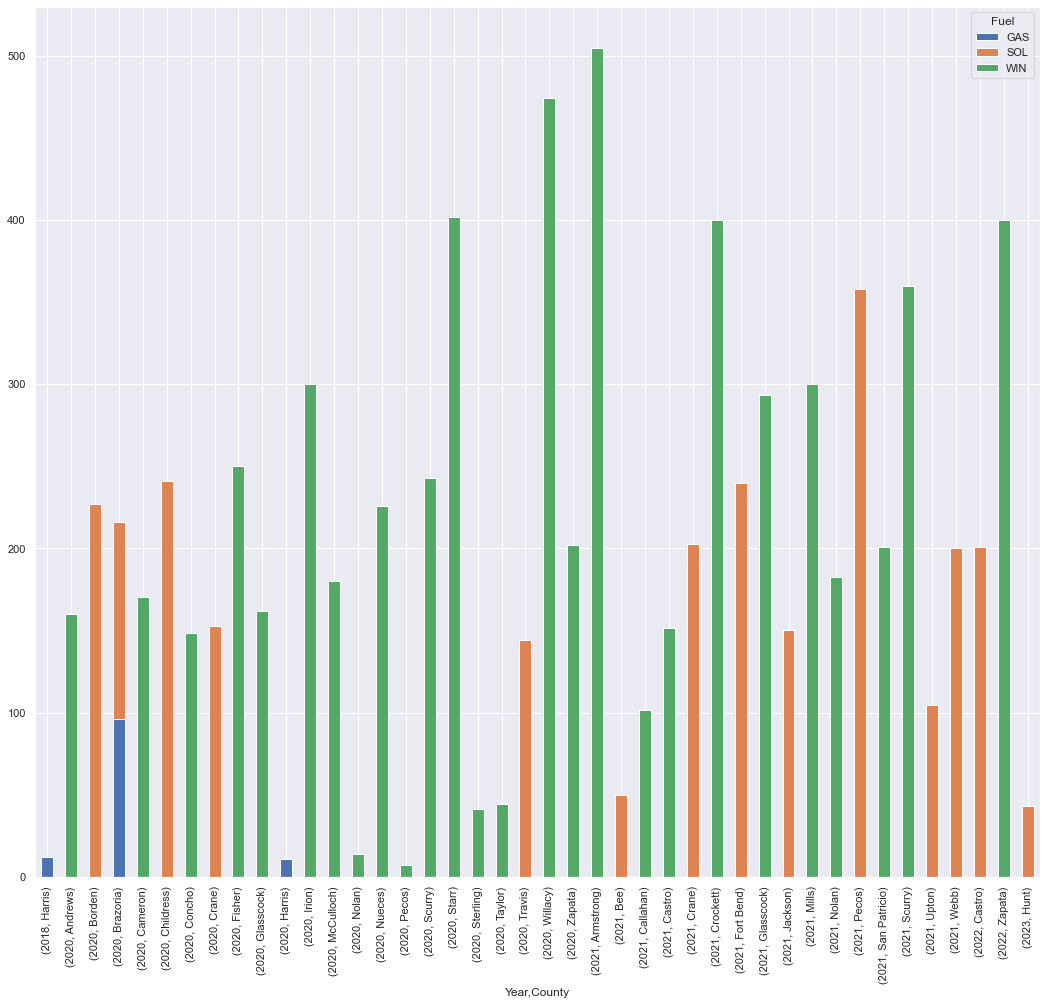

In [70]:
import matplotlib.pyplot as plt
df_plot = df[['Projected COD', 'County', 'Fuel', 'Capacity (MW)']]
df_plot['Year'] = pd.to_datetime(df_plot['Projected COD']).dt.to_period('Y')
df_plot.drop('Projected COD', axis=1, inplace=True)

df_plot_trunc = df_plot[:50] # Subset the data
df_gb = df_plot_trunc.groupby(['Year','County', 'Fuel']).sum(['Capacity (MW)'])
df_gb.unstack().plot(kind='bar', stacked=True, y='Capacity (MW)', figsize=(18, 16))

Or something like that. There are lot's of counties, so maybe not the most useful, but regardless we could subset by region then county, or grab a specific county if we want. Cool. But this could have been done in Excel, probably, since all the data is given.
What if we wanted to find something useful, from a project developer perspective, that could actually help us determine
where we should put projects given that the queue is long and we're late to the party?

For that, we might want to know what _substation_ the projects are trying to connect to, where those are, and
see if we can't be smarter than the average bear with our next queue request. But for that we need to get the
lats and lons of the substations, since they aren't given in the sheet. Finally, we're in "use python" territory.

There's a shapefile available for this data from ArcGIS marketplace:
[source](https://hifld-geoplatform.opendata.arcgis.com/datasets/electric-substations?geometry=-91.910%2C36.930%2C-71.212%2C39.942)

It's been placed in the `data` folder along with the auxillary files.

In [23]:
import shapefile
import pprint
pp = pprint.PrettyPrinter()

file = shapefile.Reader('data/Substations.shp')
fields = file.fields
pp.pprint('Fields')
pp.pprint(fields)

records = file.records()
pp.pprint('Records')
pp.pprint(records[0:5])

'Fields'
[('DeletionFlag', 'C', 1, 0),
 ['FID', 'N', 5, 0],
 ['ID', 'C', 6, 0],
 ['NAME', 'C', 54, 0],
 ['CITY', 'C', 31, 0],
 ['STATE', 'C', 2, 0],
 ['ZIP', 'C', 13, 0],
 ['TYPE', 'C', 13, 0],
 ['STATUS', 'C', 13, 0],
 ['COUNTY', 'C', 20, 0],
 ['COUNTYFIPS', 'C', 13, 0],
 ['COUNTRY', 'C', 3, 0],
 ['LATITUDE', 'N', 24, 15],
 ['LONGITUDE', 'N', 24, 15],
 ['NAICS_CODE', 'C', 6, 0],
 ['NAICS_DESC', 'C', 44, 0],
 ['SOURCE', 'C', 249, 0],
 ['SOURCEDATE', 'D', 8, 0],
 ['VAL_METHOD', 'C', 13, 0],
 ['VAL_DATE', 'D', 8, 0],
 ['LINES', 'N', 24, 15],
 ['MAX_VOLT', 'N', 24, 15],
 ['MIN_VOLT', 'N', 24, 15],
 ['MAX_INFER', 'C', 13, 0],
 ['MIN_INFER', 'C', 13, 0]]
'Records'
[Record #0: [1, '148065', 'TAP148065', 'WILSON', 'NC', '27893', 'TAP', 'IN SERVICE', 'WILSON', '37195', 'USA', 35.74720410000003, -77.99718219999994, '221121', 'ELECTRIC BULK POWER TRANSMISSION AND CONTROL', 'IMAGERY', datetime.date(2014, 6, 13), 'IMAGERY/OTHER', datetime.date(2015, 8, 14), 3.0, -999999.0, -999999.0, 'NOT AVAILABL

In [31]:
# Let's load all this data into a dataframe
# I'm sure there are more elegant ways to unpack this data but this works:

columns = list(pd.DataFrame(fields)[0])[1:]
subs = pd.DataFrame(records, columns=columns)
print(f'There are {len(subs)} substations in the list.')

# We just want ERCOT so I'll filter by Texas
subs = subs[subs['STATE'] == 'TX']
subs.reset_index(inplace=True)
names = subs['NAME']
print(f'There are {len(subs)} substations in the list in Texas.')

There are 68991 substations in the list.
There are 4929 substations in the list in Texas.


In [131]:
# We also need to drastically clean up the remaining Texas substations
# Remove the UNKNOWN and TAP substations, since they are ambiguous.
filter_titles = [] # It'll be useful later...
filter_names = []
for name in names:
    if name.startswith('UNKNOWN') or name.startswith('TAP'):
        continue

    else:
        filter_names.append(name)
        title = name.title()
        filter_titles.append(title)
        
print(f'Before we had {len(names)} substations.')
print(f'Now we have {len(filter_titles)}. An improvement!')

Before we had 4929 substations.
Now we have 1433. An improvement!


In [132]:
# If we look at the names given in the IxQ we see that they are so dumb and hard to parse it should be a crime.
# Ain't nobody able to join on this. Gotta clean them up.

old_strings = list(df['POI Location'])
print("See they are terrible! All different formats, hard to split, some have voltage some don't...")
pp.pprint(old_strings[0:20])

See they are terrible! All different formats, hard to split, some have voltage some don't...
['85000 Nelson Sharpe 345kV',
 'tap 345kV 11305 Dermott - 60706 Kirchhoff',
 'tap 345kV 79500 Alibates - 79503 Tule Canyon',
 'tap 345kV 8455 Lon Hill -8606 Goddard',
 '80219 Lobo 345kV',
 '76602 Horse Crossing 138kV',
 '59903 Bearkat 345kV',
 'tap 138kV 7336 Gillie - 3650 Elgin',
 '79501 Ogallala 345kV',
 '23912 Ogallala 345kV',
 '42970 Nasa 138kV',
 '42100 Hudson 138kV',
 '80355 Del Sol 345kV',
 'tap 345kV 1444 Brown – 3422 Killeen',
 'tap 138kV 6480 SAPS - 6365 Yellow Jacket',
 '76005 Schneeman Draw 345kV',
 '8957 Lopeno 138kV',
 '76020 SONNE 138-kV',
 '76002 Bakersfield 345kV',
 '76002 Bakersfield 345kV']


In [134]:
# We're going to need to use some regular expressions, I think
import re
strings = []
nan_count = 0
for string in old_strings:

    try: # Sometimes there are nans, let's skip them 
        
        new_string = re.sub(r'\d+(kV)?', '', string) # Remove integers, and the voltage units if they are there
        new_string = re.sub(r'tap', '', new_string) # Remove the Tap indicator...
        new_string = re.sub(r'Tap', '', new_string) # ...even if it's capitalized.
        new_string = re.sub(r'\.', '', new_string) # and any periods
        new_string = new_string.split('-') # Sometimes the POI is in between the two substations, so it indicates both, so let's split and store them both
        final = []
        
        for string_part in new_string: # Clean up the surrounding spaces
            string_part = string_part.strip()
            final.append(string_part)
        strings.append(final)
   
    except TypeError:
        nan_count += 1
        strings.append('Missing')

poi_dict = dict(zip(old_strings, strings)) # Useful later
        
from_queue = [item for sublist in strings for item in sublist] # When we split on multiple substations, we created a list of lists. Let's flatten it
from_subs = filter_titles

# Now let's see how many overlap that we can work with
set_queue = set(from_queue) # Grab uniques
set_subs = set(from_subs) # Grab uniques

overlap = []
no_match = []
for item in set_queue:
    if item in set_subs:
        overlap.append(item)
    else:
        no_match.append(item)
        continue


print(f'There are {len(overlap)} substations with projects requesting interconnection we now have lats and lons for.')
print(f'There are still {len(no_match)} interconnection request POIs for which we have no match.')
print(f'There are {nan_count} interconnection request projects which do not have a POI Location.')

There are 81 substations with projects requesting interconnection we now have lats and lons for.
There are still 343 interconnection request POIs for which we have no match.
There are 1 interconnection request projects which do not have a POI Location.


We were only able to match 81 substations, but I'm sure with more time and cleaning we could get lats and lons for all of them. 
However, getting clean, accesible data is hopefully done before hand so that data science can occur, so we'll move on to that with our matches. We'll filter both the substation list and the interconnection queue projects by the overlapping list

In [190]:
# Going to make a column for the nice substation name in the IxQ and then filter, then doing some renaming since things have been jumbled

df['Substation'] = df['POI Location'].map(poi_dict)
df['Substation1'] = df['Substation'].str[0]
df['Substation2'] = df['Substation'].str[1]
df_ixq = df[df['Substation1'].isin(overlap) | df['Substation2'].isin(overlap)]
df_ixq.reset_index(inplace=True)

subs['Substation'] = subs['NAME'].str.title()
df_subs = subs[subs['Substation'].isin(overlap)]
df_subs.reset_index(inplace=True)
df_subs = df_subs[['Substation','LATITUDE','LONGITUDE']]
df_subs.set_index('Substation', inplace=True)

df_ixq = df_ixq.join(df_subs, on='Substation1') # First join in the substations
df_final = pd.merge(df_ixq, df_subs, how='left', left_on=['Substation2'], right_on=['Substation']) # then merge in the rest
df_final['LATITUDE'] = df_final['LATITUDE_x'].combine_first(df_final['LATITUDE_y']) # clean up the merges
df_final['LONGITUDE'] = df_final['LONGITUDE_x'].combine_first(df_final['LONGITUDE_y'])
df_final = df_final[['Project Name','Capacity (MW)', 'Fuel', 'Technology', 'LATITUDE', 'LONGITUDE']] # Grab the columns we want, and voila!

print(df_final.head())
print(f"The number of missing Lat/Lons for a POI substation is...{df_final['LATITUDE'].isna().sum()}!") # Check that we have everything


         Project Name  Capacity (MW) Fuel Technology   LATITUDE   LONGITUDE
0    WKN Amadeus Wind         250.12  WIN         WT  32.860171 -101.008850
1      Goodnight Wind         504.40  WIN         WT  35.254890 -101.359448
2       Corazon Solar         200.00  SOL         PV  27.578804  -99.276012
3  Pflugerville Solar         144.00  SOL         PV  30.334676  -97.340571
4           Hart Wind         151.50  WIN         WT  34.519588 -102.038710
The number of missing Lat/Lons for a POI substation is...0!


# Okay, visualize!

In [210]:
import geopandas as gpd
states = gpd.read_file('data/usa-states-census-2014.shp')
crs = {'init':"EPSG:3395"}

In [211]:
from shapely.geometry import Point, Polygon
projects = [Point(xy) for xy in zip( df_final['LONGITUDE'], df_final['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df_final, crs = crs, geometry=projects)
geo_df.head()

/Users/kladar/Dropbox (Personal)/Personal/Career/Applying/Enel/example_code_rk/ercot_iq/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Project Name,Capacity (MW),Fuel,Technology,LATITUDE,LONGITUDE,geometry
0,WKN Amadeus Wind,250.12,WIN,WT,32.860171,-101.008850,POINT (-101.00885 32.86017)
1,Goodnight Wind,504.40,WIN,WT,35.254890,-101.359448,POINT (-101.35945 35.25489)
2,Corazon Solar,200.00,SOL,PV,27.578804,-99.276012,POINT (-99.27601 27.57880)
3,Pflugerville Solar,144.00,SOL,PV,30.334676,-97.340571,POINT (-97.34057 30.33468)
4,Hart Wind,151.50,WIN,WT,34.519588,-102.038710,POINT (-102.03871 34.51959)


In [212]:
print(set(df_final['Technology']))

{'BA', 'CC', 'ST', 'WT', 'OT', 'PV', 'GT'}


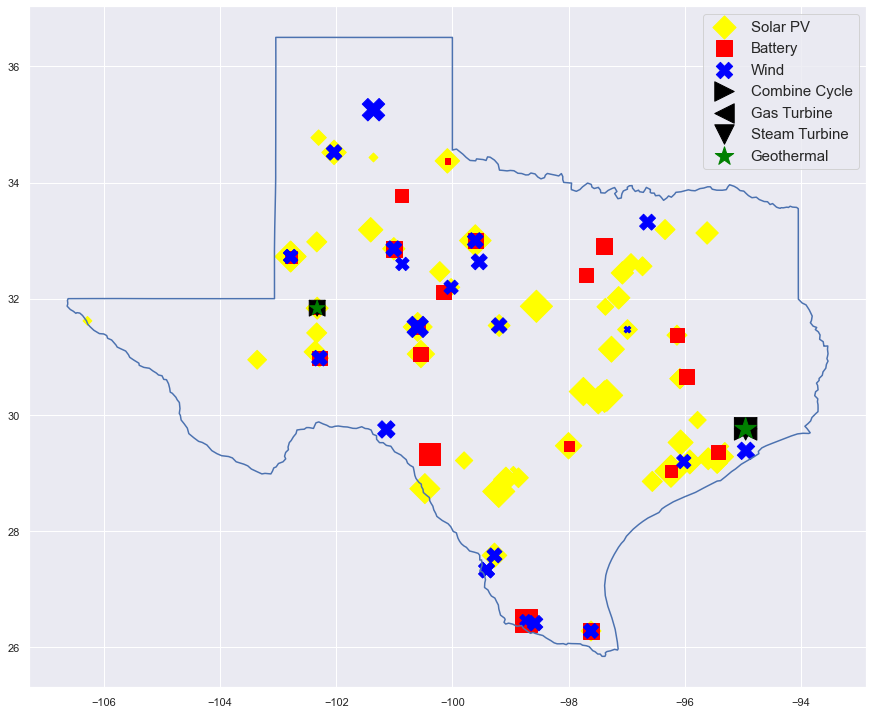

In [240]:
fig, ax = plt.subplots(figsize=(15,15))

states[states['NAME'] == 'Texas'].boundary.plot(ax=ax, figsize=(12, 12))
geo_df[geo_df['Technology']=='PV'].plot(ax=ax, color='yellow', marker='D',markersize = df_final['Capacity (MW)'], label='Solar PV')
geo_df[geo_df['Technology']=='BA'].plot(ax=ax, color='red', marker='s',markersize = df_final['Capacity (MW)'], label='Battery')
geo_df[geo_df['Technology']=='WT'].plot(ax=ax, color='blue', marker='X',markersize = df_final['Capacity (MW)'], label='Wind')
geo_df[geo_df['Technology']=='CC'].plot(ax=ax, color='black', marker='>',markersize = df_final['Capacity (MW)'], label='Combine Cycle')
geo_df[geo_df['Technology']=='CC'].plot(ax=ax, color='black', marker='<',markersize = df_final['Capacity (MW)'], label='Gas Turbine')
geo_df[geo_df['Technology']=='CC'].plot(ax=ax, color='black', marker='v',markersize = df_final['Capacity (MW)'], label='Steam Turbine')
geo_df[geo_df['Technology']=='CC'].plot(ax=ax, color='green', marker='*',markersize = df_final['Capacity (MW)'], label='Geothermal')

plt.legend(prop={'size': 15})

## Obviously the above could be prettier! However...

However, I'd like to talk about where we could go from here, applying data science directly to the forehead. There are lots of directions, keeping in mind the structure of the electric grid. But asking the right questions in data science is often much harder than finding the answer, which is why good infrastructure and clean data are paramount: when you figure out the question, it becomes simply a tour of the existing workshop to find the tools that help you get the answer. If everytime you needed to cut a piece of wood you had to drive 100 miles to use a friend's saw, your real problem isn't that you have a piece of wood to cut...it's that you don't have a saw.

So what do we want to know about the interconnection queue? I'm going to list some potential problems and how I would solve them.

1. What if we wanted to know where developers are clustering their projects and where there might be some gaps to fill with intermittent generation that have been overlooked? We could perform a technology-based k-means or -medians clustering of projects, specifically wind and solar as these will be highly correlated in output based on geography and meteorology. We could even build a k-nearest neighbor model to figure out where the isolated projects are. sklearn.KMeans (or the functions set for k-means I developed over in my [Data Science From Scratch](https://github.com/Kladar/Data-Science-From-Scratch) code along).

2. What if we wanted to predict where the next queue project would go in? Based on the pattern and history of interconnection requests, we could perform a simple regression as to where the next project will be added (probably reasonably predicted at the zonal level) and when it will pass its studies. Taking a rolling average "time to pass" each study in each zone would give a good idea of the time to interconnection. Why sit in traffic for a popular POI in a zone when you could take the backroads and size your project accordingly? With just basic stats on each process for interconnection, you could develop the Waze of Interconnection Queues. "Never connect to the Bearkat Substation with solar if there are more than 3 projects ahead of you!" Things like that.

3. What if we wanted to know the average size of a battery in a paired regime with wind? with solar? How is that paired sizing ratio changing over time? What does that tell us about developer strategy ideas on merchant plants and what kind of operations their batteries are signing up for? A 100MW solar paired with 10MW battery is aiming to operate very differently than a 50MW solar plant paired with a 50MW battery. Same story with wind, and trifecta systems.

4. What if we wanted to assess the value of each project in the queue? Looking at historical generation and prices at certain nodes, we could reasonable calculate cashflows for given projects, discounted by their queue position, and update them every month with how they progress through the pipeline, spotting the most valuable projects before anyone else (for acquisition) or spotting overvalued positions and steering other developers clear. You could make products out of just knowing the queue better than anyone else (especially since no one knows the queue all that well). 

5. What if we wanted to know how policy decisions show up in developer strategy? Or reserve margins? Or how reserve margins affect developer strategy? The amount of energy storage in the interconnection queue in ERCOT went from zero MW in April 2018 to more than 13,000MW in June of this year. Based on developers entering the queue, we can see how each of them reacts to news. Who is early? Who is late? Who is taking a different strategy than everyone else and why? When FERC Order 841 came in, how long did it take to see a spike in queue amounts? If a storage ITC were passed, would it spike the queue again or are we at saturation? All discernible from the queue data. 

6. What if we really, really, really wanted to use RL? Well for RL you just need an environment and a state with a reward mechanism. Since interconnection queue positions are slightly fungible and tradeable, we could turn the bilateral trading interconnection queue into a variable rewards game, simply trading actual queue positions in bilateral contracts with developers based on our agent's determination of the options value of each position for each technology at each zone at each moment in time. Based on historical project value and process through the queue, I imagine an intelligent agent could spot undervalued and overvalued project positions. I'm reaching here, obviously, but it's conceivable.


You see where I'm going with this. With a few thousand rows of location and queue data, and a few hundred lines of python, we could comprehensively understand the development pipeline of every project in every ISO in the United States and have greater insight into what projects are undervalued and overvalued, what gets built and what doesn't, better than anyone else. We could sell that information. We could use it for our own development strategies. We could watch how policy affects developer strategy and how fast.